# Libraries Import

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
import re
import json
import os

In [85]:
import pickle

In [86]:
from keras.layers import Dense, Input, Embedding, LSTM, Bidirectional, Add
from keras.layers import Dot, Concatenate, Activation, LayerNormalization
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants

In [87]:
RELATIVE_PATH = r'drive/MyDrive/colab_outputs/'

os.makedirs(RELATIVE_PATH, exist_ok=True)

In [88]:
DATA_FILE_PATH = r'fra.txt'

In [89]:
X_TOKENIZER_PATH = RELATIVE_PATH + r'x_tokenizer.pkl'
Y_TOKENIZER_PATH = RELATIVE_PATH + r'y_tokenizer.pkl'

X_TOKENIZER_TOKENS_ALLOWED_PATH = RELATIVE_PATH + r'x_tokenizer_tokens_allowed.json'
Y_TOKENIZER_TOKENS_ALLOWED_PATH = RELATIVE_PATH + r'y_tokenizer_tokens_allowed.json'

X_TOKENIZER_NUM_WORDS = 3000
Y_TOKENIZER_NUM_WORDS = 3000

X_TOKENIZER_OOV_TOKEN = '<OOV_X>'
Y_TOKENIZER_OOV_TOKEN = '<OOV_Y>'

In [90]:
START_TOKEN = 'START_TOKEN'
END_TOKEN = 'END_TOKEN'

INPUT_SEQUENCE_LEN = 35  # the longest input str can not exceed this numbers of words
OUTPUT_SEQUENCE_LEN = 35 # the longest output str can not exceed this numbers of words

In [91]:
MODEL_WEIGHTS_PATH = RELATIVE_PATH + r'train_model_weights.weights.h5'
MODEL_ENCODER_PATH = RELATIVE_PATH + r'model_encoder.keras'
MODEL_DECODER_PATH = RELATIVE_PATH + r'model_decoder.keras'
MODEL_ATTENTION_PATH = RELATIVE_PATH + r'model_attention.keras'

In [92]:
ENCODER_EMBEDDING_DIM = 92
DECODER_EMBEDDING_DIM = 92

CONTEXT_VECTOR_LEN = 275

In [93]:
BATCH_SIZE = 336
N_EPOCHS = 10

# Functions

In [94]:
def pkl_save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def pkl_load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [95]:
def json_save_obj(obj, file_name):
    with open(file_name, 'w', encoding='UTF+8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def json_load_obj(file_name):
    with open(file_name, 'r', encoding='UTF+8') as f:
        return json.load(f)

# Dataset Import

In [96]:
data_list = []

with open(DATA_FILE_PATH,'r', encoding='UTF+8') as file:
    while True:
        line = file.readline()
        if not line:
            break

        x, y = line.strip().split('\t')[0:2]

        data_list.append({
            "X": x, "Y": y
        })

df = pd.DataFrame(data_list)
del data_list

In [97]:
df

,X,Y
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run!,Courez !
4,Who?,Qui ?
...,...,...
167125,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
167126,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
167127,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
167128,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


# Dataset Exploration

In [98]:
pd.concat([df.head(),df.tail()])

,X,Y
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run!,Courez !
4,Who?,Qui ?
167125,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
167126,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
167127,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
167128,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...
167129,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...


In [99]:
df.describe(include='all')

,X,Y
count,167130,167130
unique,116830,158527
top,I can't tell you how happy I am that you've co...,Je vais bien.
freq,32,10


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167130 entries, 0 to 167129
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   X       167130 non-null  object
 1   Y       167130 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


# Dataset Preprocessing

In [101]:
df.isna().sum()

,0
X,0
Y,0


In [102]:
df.duplicated().sum()

np.int64(0)

Remove special characters

In [103]:
def clean_str(text:str):
    text = str(text).lower().strip()

    text = re.sub(re.compile(r"[^A-Za-z0-9]"), ' ',text )
    text = re.sub(re.compile(r"\s+"), ' ',text )

    return text.strip()

df['X'] = df['X'].apply(clean_str)
df['Y'] = df['Y'].apply(clean_str)

In [104]:
pd.concat([df.head(),df.tail()])

,X,Y
0,go,va
1,hi,salut
2,run,cours
3,run,courez
4,who,qui
167125,a carbon footprint is the amount of carbon dio...,une empreinte carbone est la somme de pollutio...
167126,death is something that we re often discourage...,la mort est une chose qu on nous d courage sou...
167127,since there are usually multiple websites on a...,puisqu il y a de multiples sites web sur chaqu...
167128,if someone who doesn t know your background sa...,si quelqu un qui ne conna t pas vos ant c dent...
167129,it may be impossible to get a completely error...,il est peut tre impossible d obtenir un corpus...


# Dataset Visulization

In [105]:
plt.style.use(plt.style.available[12])

In [106]:
df['x_length'] = df['X'].apply( lambda x: len(str(x).split(' ')))
df['y_length'] = df['Y'].apply( lambda y: len(str(y).split(' ')) )

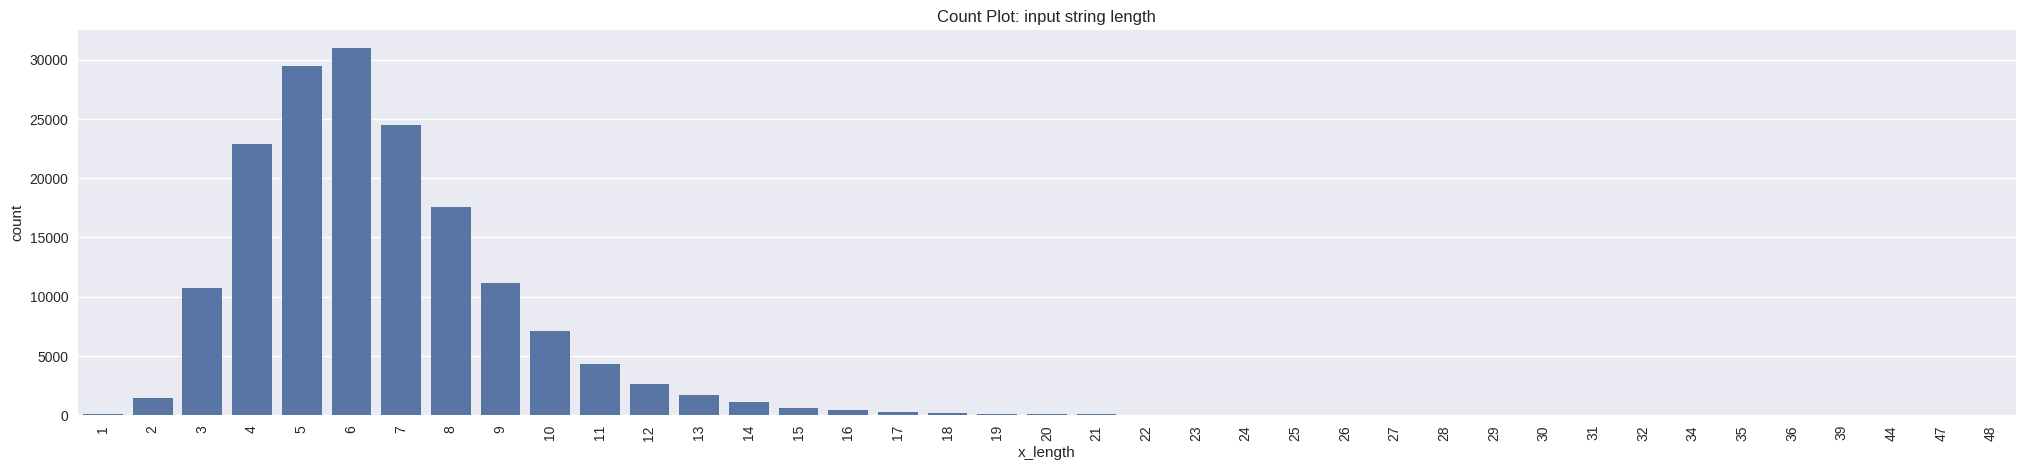

In [107]:
plt.figure(figsize=(25,5))
plt.title('Count Plot: input string length')
sns.countplot(df,x='x_length')
plt.xticks(rotation=90)
plt.show()

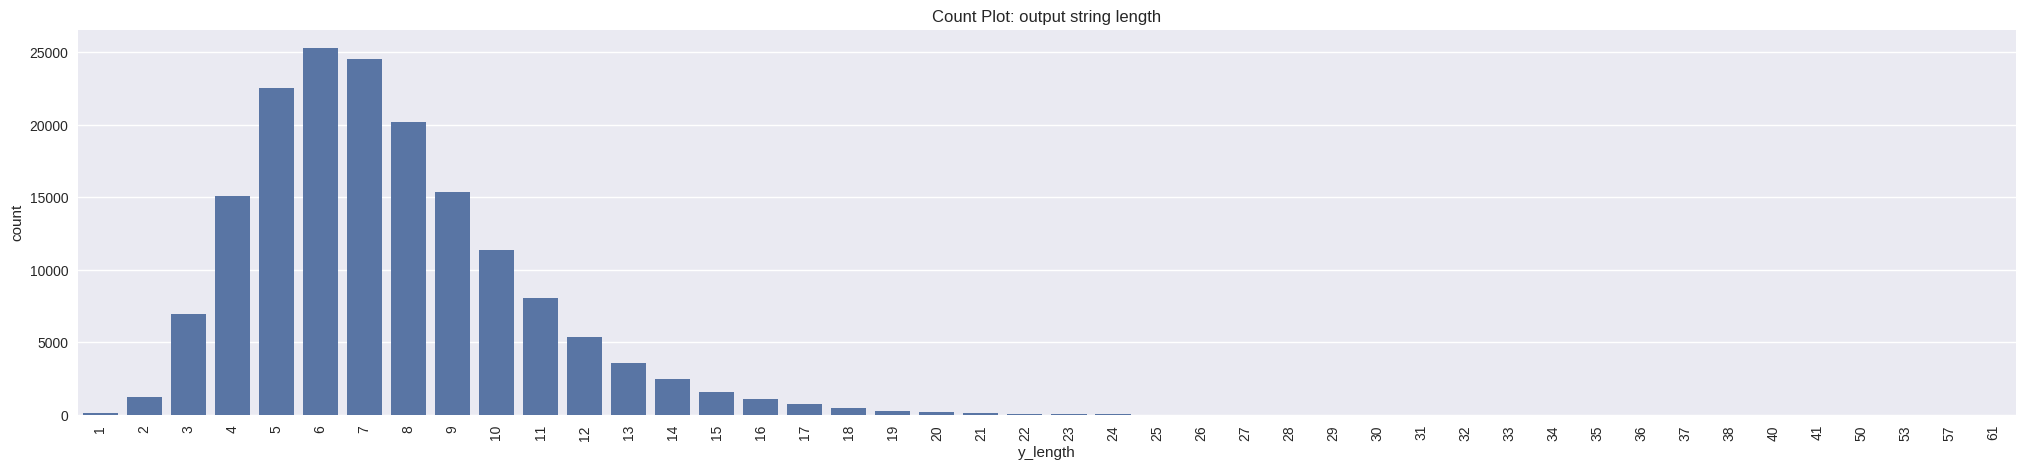

In [108]:
plt.figure(figsize=(25,5))
plt.title('Count Plot: output string length')
sns.countplot(df,x='y_length')
plt.xticks(rotation=90)
plt.show()

# Initialize Encoder and Decoder Data

data

In [109]:
X = list(df.loc[:,'X'].values)
Y_input = list(df.loc[:,'Y'].values)
Y_output = list(df.loc[:,'Y'].values)

Add start & end token

In [110]:
for i in range(len(Y_input)):
    Y_input[i] = START_TOKEN + ' ' + Y_input[i]
    Y_output[i] = Y_output[i] + ' ' + END_TOKEN

In [111]:
print(f"{X[0]= }")
print(f"{X[4]= }")
print(f"{X[5436]= }")

print(f"{Y_input[0]= }")
print(f"{Y_input[4]= }")
print(f"{Y_input[5436]= }")

print(f"{Y_output[0]= }")
print(f"{Y_output[4]= }")
print(f"{Y_output[5436]= }")

X[0]= 'go'
X[4]= 'who'
X[5436]= 'i miss boston'
Y_input[0]= 'START_TOKEN va'
Y_input[4]= 'START_TOKEN qui'
Y_input[5436]= 'START_TOKEN boston me manque'
Y_output[0]= 'va END_TOKEN'
Y_output[4]= 'qui END_TOKEN'
Y_output[5436]= 'boston me manque END_TOKEN'


Tokenizer

In [112]:
if os.path.exists(X_TOKENIZER_PATH):
    print("Loading tokenizer...")
    x_tokenizer = pkl_load_obj(X_TOKENIZER_PATH,)
else:
    print("Init tokenizer")
    x_tokenizer = Tokenizer(
        filters = '',
        split = ' ',
        lower = False,
        num_words = X_TOKENIZER_NUM_WORDS,
        char_level = False,
        oov_token = X_TOKENIZER_OOV_TOKEN)

    x_tokenizer.fit_on_texts(X)

Init tokenizer


In [113]:
X_sequences = x_tokenizer.texts_to_sequences(X)

In [114]:
if os.path.exists(Y_TOKENIZER_PATH):
    print("Loading tokenizer...")
    y_tokenizer = pkl_load_obj(Y_TOKENIZER_PATH)
else:
    print("Init tokenizer")
    y_tokenizer = Tokenizer(
        filters = '',
        split = ' ',
        lower = False,
        num_words = Y_TOKENIZER_NUM_WORDS,
        char_level = False,
        oov_token = Y_TOKENIZER_OOV_TOKEN)

    y_tokenizer.fit_on_texts(Y_input + Y_output)

Init tokenizer


In [115]:
Y_input_sequences = y_tokenizer.texts_to_sequences(Y_input)
Y_output_sequences = y_tokenizer.texts_to_sequences(Y_output)

padding

In [116]:
X_sequences = pad_sequences(X_sequences,
                         maxlen=INPUT_SEQUENCE_LEN,
                         padding='post',
                         truncating='post',
                         value=0)

In [117]:
Y_input_sequences = pad_sequences(Y_input_sequences,
                         maxlen=OUTPUT_SEQUENCE_LEN,
                         padding='post',
                         truncating='post',
                         value=0)

Y_output_sequences = pad_sequences(Y_output_sequences,
                         maxlen=OUTPUT_SEQUENCE_LEN,
                         padding='post',
                         truncating='post',
                         value=0)

In [118]:
for i in [1, 4 ,5]:
    print(f"{X_sequences[i] = }")
    print(f"{Y_input_sequences[i] = }")
    print(f"{Y_output_sequences[i] = }")
    print(' ')

X_sequences[i] = array([2888,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)
Y_input_sequences[i] = array([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
Y_output_sequences[i] = array([1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
 
X_sequences[i] = array([77,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32)
Y_input_sequences[i] = array([ 2, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32)
Y_output_sequences[i] = ar

In [119]:
X_sequences = np.array(X_sequences)
Y_input_sequences = np.array(Y_input_sequences)
Y_output_sequences = np.array(Y_output_sequences)

In [120]:
print(f"{X_sequences.shape = }")
print(f"{Y_input_sequences.shape = }")
print(f"{Y_output_sequences.shape = }")

X_sequences.shape = (167130, 35)
Y_input_sequences.shape = (167130, 35)
Y_output_sequences.shape = (167130, 35)


In [121]:
print(f"{len(x_tokenizer.word_index) = }")
print(f"{len(y_tokenizer.word_index) = }")

len(x_tokenizer.word_index) = 13948
len(y_tokenizer.word_index) = 19954


# Building the Sequence-to-Sequence Model

In [122]:
# Encoder
encoder_input_layer = Input(shape= (X_sequences.shape[-1],) )

encoder_embedding_layer = Embedding(input_dim = 1 + X_TOKENIZER_NUM_WORDS,
                                    output_dim= ENCODER_EMBEDDING_DIM,
                                    mask_zero=True
                                    )

encoder_embedding_output = encoder_embedding_layer(encoder_input_layer)

encoder_lstm_layer_1 = Bidirectional(LSTM(units=CONTEXT_VECTOR_LEN, return_sequences=True))
encoder_lstm_layer_2 = LSTM(units=CONTEXT_VECTOR_LEN, return_sequences=True, return_state=True)

encoder_lstm_output_seq, encoder_lstm_state_h, encoder_lstm_state_c = encoder_lstm_layer_2(encoder_lstm_layer_1(encoder_embedding_output))

context_vector_output = [encoder_lstm_state_h, encoder_lstm_state_c]

encoder_model = Model(
    encoder_input_layer,[encoder_lstm_output_seq] + context_vector_output,
    name = "encoder_model"
)

In [123]:
encoder_model.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 35, 92)    │    276,092 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 35)        │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 35, 550)   │    809,600 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 35, 275), │    908,600 │ bidirectional_1[… │
│                     │ (None, 275),      │            │ not_equal_3[0][0] │
│                     │ (None, 275)]      │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,994,292 (7.61 MB)

 Trainable params: 1,994,292 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Decoder
decoder_input_layer = Input(shape= (Y_input_sequences.shape[-1], ) )
decoder_state_h_input_layer = Input(shape=(CONTEXT_VECTOR_LEN,))
decoder_state_c_input_layer = Input(shape=(CONTEXT_VECTOR_LEN,))
decoder_state_input_layer = [decoder_state_h_input_layer, decoder_state_c_input_layer]

decoder_embedding_layer = Embedding(input_dim = 1 + Y_TOKENIZER_NUM_WORDS,
                                    output_dim= DECODER_EMBEDDING_DIM,
                                    mask_zero=True)

decoder_embedding_output = decoder_embedding_layer(decoder_input_layer)

decoder_lstm_layer_1 = LSTM(
    units=CONTEXT_VECTOR_LEN,
    return_state=True,
    return_sequences=True,
)

decoder_lstm_layer_2 = LSTM(
    units=CONTEXT_VECTOR_LEN,
    return_state=True,
    return_sequences=True,
)


decoder_lstm_output_seq_1, decoder_lstm_state_h_1, decoder_lstm_state_c_1 = decoder_lstm_layer_1(decoder_embedding_output,
                                                                                     initial_state= decoder_state_input_layer)

decoder_layer_normalization_layer_1 = LayerNormalization()
decoder_lstm_output_seq_1_norm = decoder_layer_normalization_layer_1(decoder_lstm_output_seq_1)

decoder_lstm_output_seq_2, decoder_lstm_state_h_2, decoder_lstm_state_c_2 = decoder_lstm_layer_2(decoder_lstm_output_seq_1_norm)


decoder_lstm_output_seq = Add()([decoder_lstm_output_seq_1_norm, decoder_lstm_output_seq_2])

decoder_layer_normalization_layer_2 = LayerNormalization()
decoder_lstm_output_seq_norm = decoder_layer_normalization_layer_2(decoder_lstm_output_seq)

decoder_model = Model(
    [decoder_input_layer] + decoder_state_input_layer,
    decoder_lstm_output_seq_norm,
    name = "decoder_model"
)

In [125]:
decoder_model.summary()

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 35, 92)    │    276,092 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 275)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 275)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 35, 275), │    404,800 │ embedding_3[0][0… │
│                     │ (None, 275),      │            │ input_layer_15[0… │
│                     │ (None, 275)]      │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 35, 275)   │        550 │ lstm_6[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 35)        │          0 │ input_layer_14[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 35, 275), │    606,100 │ layer_normalizat… │
│                     │ (None, 275),      │            │ not_equal_4[0][0] │
│                     │ (None, 275)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 35, 275)   │          0 │ layer_normalizat… │
│                     │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 35, 275)   │        550 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,288,092 (4.91 MB)

 Trainable params: 1,288,092 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
# Attention Mechanism
atention_mech_encoder_seq_input_layer = Input(shape= (INPUT_SEQUENCE_LEN, CONTEXT_VECTOR_LEN) )
atention_mech_decoder_seq_input_layer = Input(shape= (OUTPUT_SEQUENCE_LEN, CONTEXT_VECTOR_LEN) )

atention_mech_score_value = Dot(axes = [2, 2])([atention_mech_decoder_seq_input_layer, atention_mech_encoder_seq_input_layer])

atention_mech_weights_value = Activation('softmax')(atention_mech_score_value)

atention_mech_context_vector_value= Dot(axes = [2, 1])([atention_mech_weights_value, atention_mech_encoder_seq_input_layer])

atention_mech_combined_value = Concatenate(axis=-1)([atention_mech_context_vector_value, atention_mech_decoder_seq_input_layer])

attention_output_layer = Dense(units= 1 + Y_TOKENIZER_NUM_WORDS, activation='softmax')
attention_mech_dense_value = attention_output_layer(atention_mech_combined_value)

attention_model = Model(
    [atention_mech_encoder_seq_input_layer, atention_mech_decoder_seq_input_layer],
    attention_mech_dense_value,
    name = "attention_model"
)

In [127]:
attention_model.summary()

Model: "attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 35, 275)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 35, 275)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 35, 35)    │          0 │ input_layer_18[0… │
│                     │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35)    │          0 │ dot_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 35, 275)   │          0 │ activation_2[0][… │
│                     │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 35, 550)   │          0 │ dot_5[0][0],      │
│ (Concatenate)       │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 35, 3001)  │  1,653,551 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,653,551 (6.31 MB)

 Trainable params: 1,653,551 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# Model
train_model_input_layer = Input(shape= (X_sequences.shape[-1],) )
train_model_target_input_layer = Input(shape= (Y_input_sequences.shape[-1], ) )

train_model_encoder_lstm_output_seq, train_model_context_vector_h, train_model_context_vector_c = encoder_model(train_model_input_layer)

train_model_deocder_lstm_output_seq = decoder_model([train_model_target_input_layer] + [train_model_context_vector_h, train_model_context_vector_c])

attention_model_output = attention_model([train_model_encoder_lstm_output_seq, train_model_deocder_lstm_output_seq])

training_model = Model(
    [train_model_input_layer, train_model_target_input_layer],
    attention_model_output,
    name = "training_model"
)

In [129]:
training_model.compile(
    optimizer = 'rmsprop',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [130]:
training_model.summary()

Model: "training_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, 35, 275), │  1,994,292 │ input_layer_19[0… │
│ (Functional)        │ (None, 275),      │            │                   │
│                     │ (None, 275)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ (None, 35, 275)   │  1,288,092 │ input_layer_20[0… │
│ (Functional)        │                   │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_model     │ (None, 35, 3001)  │  1,653,551 │ encoder_model[0]… │
│ (Functional)        │                   │            │ decoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,935,935 (18.83 MB)

 Trainable params: 4,935,935 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

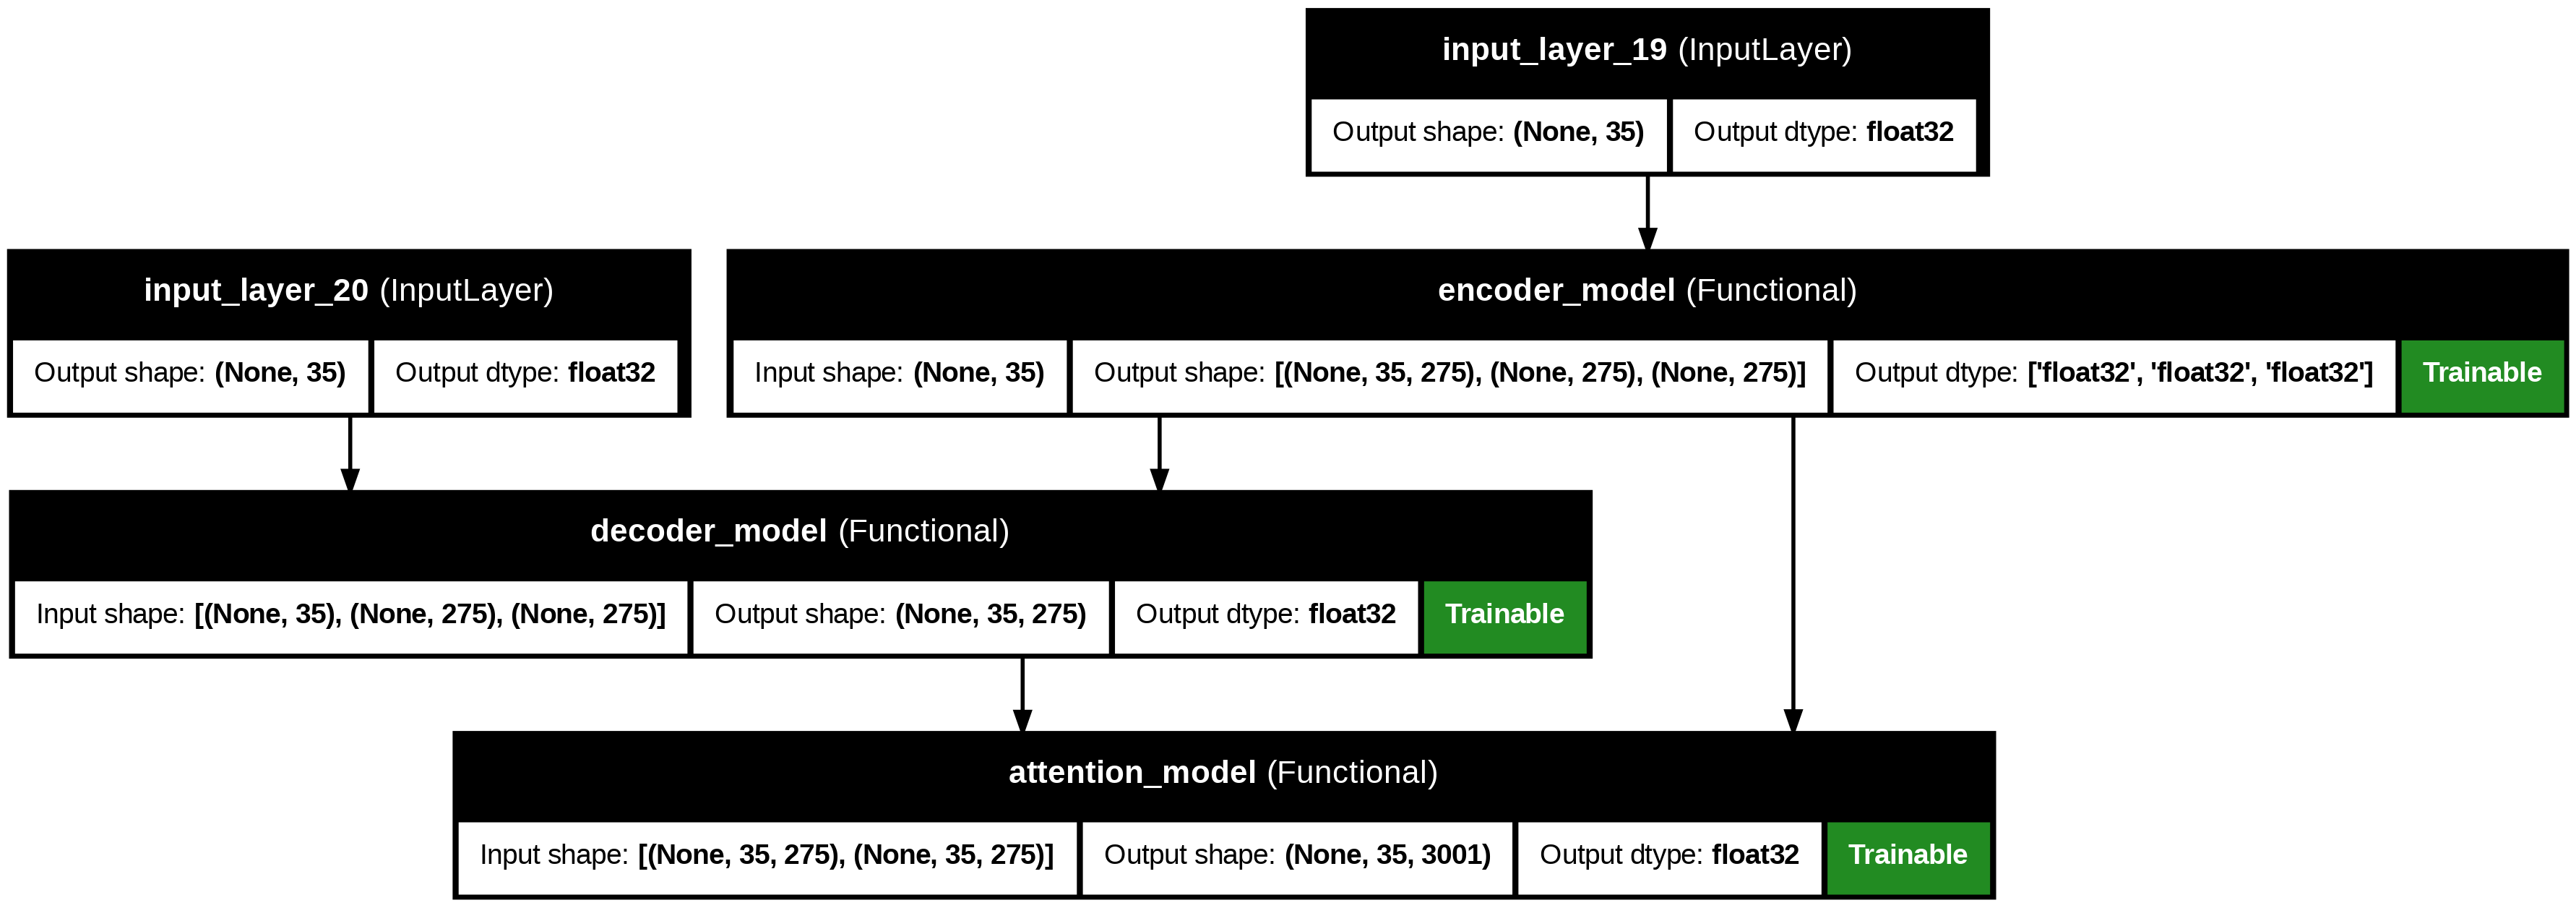

In [131]:
plot_model(
    training_model,
    to_file= RELATIVE_PATH + 'training_model.png',
    show_shapes=True,
    dpi =200,
    show_layer_names=True,
    expand_nested=False,
    show_layer_activations=True,
    show_trainable=True,
    show_dtype=True,
)

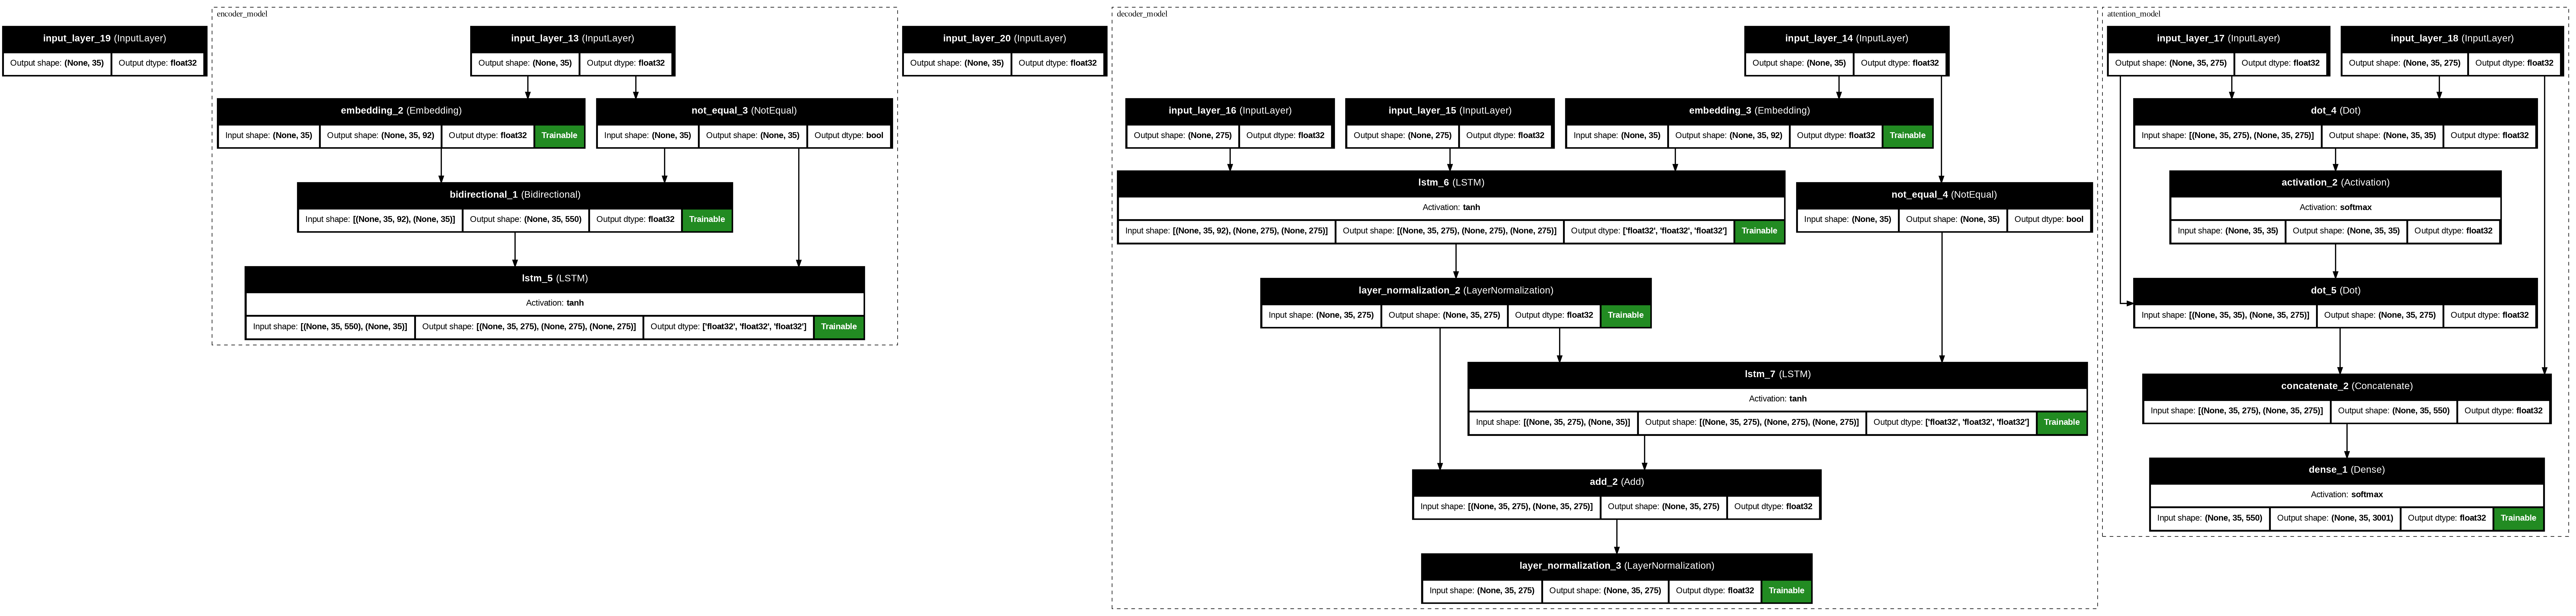

In [132]:
plot_model(
    training_model,
    to_file= RELATIVE_PATH + 'training_model_show_nested.png',
    show_shapes=True,
    dpi =200,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
    show_trainable=True,
    show_dtype=True,
)

# Model Load Weights & Callbacks

In [133]:
if os.path.exists(MODEL_WEIGHTS_PATH):
    print("Loading model weights...")
    training_model.load_weights(MODEL_WEIGHTS_PATH)
else:
    print("Init model weights...")

Init model weights...


In [134]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        mode='min',
                                        restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_WEIGHTS_PATH,
    save_weights_only=True,
    # monitor='val_loss',
    monitor='loss',
    mode='min',
    save_best_only=True)

# Model Training

In [135]:
training_model.fit(
    [X_sequences, Y_input_sequences],
    Y_output_sequences,
    batch_size=BATCH_SIZE,
    epochs= N_EPOCHS,
    validation_split=0.2,
    # callbacks = [early_stopping_callback, model_checkpoint_callback]
    callbacks = [model_checkpoint_callback]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_model' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 63s 145ms/step - accuracy: 0.8346 - loss: 1.1722 - val_accuracy: 0.7567 - val_loss: 1.3693
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - accuracy: 0.8909 - loss: 0.5689 - val_accuracy: 0.7710 - val_loss: 1.2340
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - accuracy: 0.9080 - loss: 0.4477 - val_accuracy: 0.7836 - val_loss: 1.1280
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 87s 166ms/step - accuracy: 0.9185 - loss: 0.3740 - val_accuracy: 0.7902 - val_loss: 1.0672
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - accuracy: 0.9267 - loss: 0.3215 - val_accuracy: 0.7870 - val_loss: 1.0829
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 87s 168ms/step - accuracy: 0.9323 - loss: 0.2863 - val_accuracy: 0.7978 - val_loss: 1.0133
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 77s 157ms/step - accuracy: 0.9369 - loss: 0.2592 - val_accuracy: 0.8023 - val_loss: 0.9832
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.9410 - loss: 0.2378 - val

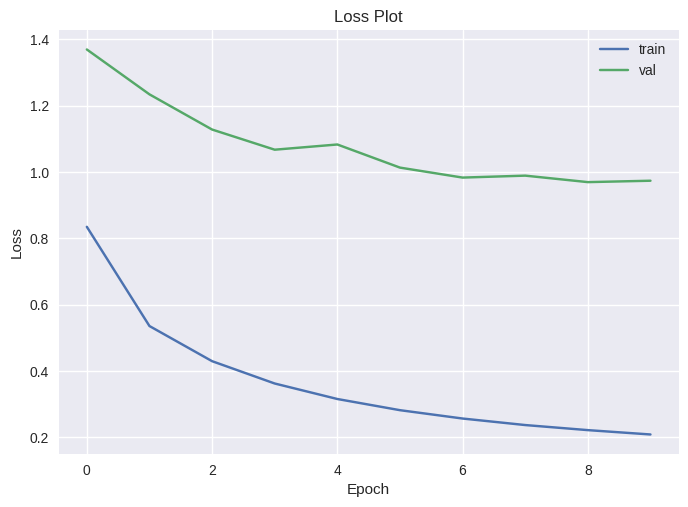

In [136]:
plt.title('Loss Plot')
plt.plot( training_model.history.history['loss'], label = 'train')
plt.plot( training_model.history.history['val_loss'], label = 'val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

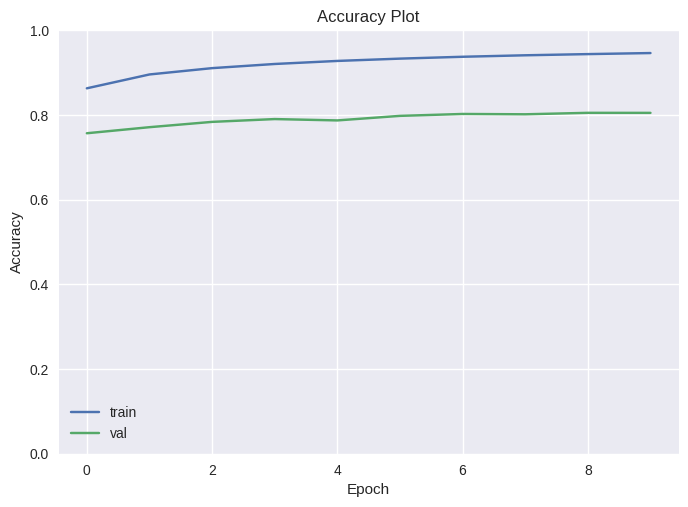

In [137]:
plt.title('Accuracy Plot')
plt.plot(training_model.history.history['accuracy'], label = 'train')
plt.plot(training_model.history.history['val_accuracy'], label = 'val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

# Building the Inference Model

Encoder

In [138]:
inference_encoder_model = encoder_model

Decoder

In [139]:
# Decoder
inference_decoder_input = Input(shape=(1,))

inference_decoder_input_state_h = Input(shape=(CONTEXT_VECTOR_LEN,))
inference_decoder_input_state_c = Input(shape=(CONTEXT_VECTOR_LEN,))
inference_decoder_states_inputs = [inference_decoder_input_state_h, inference_decoder_input_state_c]

inference_decoder_embedding = decoder_embedding_layer(inference_decoder_input)

inference_decoder_lstm_output_1, inference_state_h_1, inference_state_c_1 = decoder_lstm_layer_1(
    inference_decoder_embedding, initial_state=inference_decoder_states_inputs
)

inference_decoder_lstm_output_1_norm = decoder_layer_normalization_layer_1(inference_decoder_lstm_output_1)

inference_decoder_lstm_output_2, inference_state_h_2, inference_state_c_2 = decoder_lstm_layer_2(
    inference_decoder_lstm_output_1_norm
)

inference_decoder_lstm_output_seq = Add()([inference_decoder_lstm_output_1_norm, inference_decoder_lstm_output_2])
inference_decoder_lstm_output_seq_norm = decoder_layer_normalization_layer_2(inference_decoder_lstm_output_seq)

inference_decoder_states_outputs = [inference_state_h_2, inference_state_c_2]

inference_decoder_model = Model(
    [inference_decoder_input] + inference_decoder_states_inputs,
    [inference_decoder_lstm_output_seq_norm] + inference_decoder_states_outputs
)

In [140]:
inference_decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 92)     │    276,092 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 275)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 275)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 1, 275),  │    404,800 │ embedding_3[1][0… │
│                     │ (None, 275),      │            │ input_layer_22[0… │
│                     │ (None, 275)]      │            │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 275)    │        550 │ lstm_6[1][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 1)         │          0 │ input_layer_21[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 1, 275),  │    606,100 │ layer_normalizat… │
│                     │ (None, 275),      │            │ not_equal_5[0][0] │
│                     │ (None, 275)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 275)    │          0 │ layer_normalizat… │
│                     │                   │            │ lstm_7[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 275)    │        550 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,288,092 (4.91 MB)

 Trainable params: 1,288,092 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Attention Mechanism
inference_atention_mech_encoder_seq_input_layer = Input(shape=(INPUT_SEQUENCE_LEN, CONTEXT_VECTOR_LEN) )
inference_atention_mech_decoder_seq_input_layer = Input(shape= (1, CONTEXT_VECTOR_LEN) )

inference_atention_mech_score_value = Dot(axes = [2, 2])([inference_atention_mech_decoder_seq_input_layer, inference_atention_mech_encoder_seq_input_layer])

inference_atention_mech_weights_value = Activation('softmax')(inference_atention_mech_score_value)

inference_atention_mech_context_vector_value= Dot(axes = [2, 1])([inference_atention_mech_weights_value, inference_atention_mech_encoder_seq_input_layer])

inference_atention_mech_combined_value = Concatenate(axis=-1)([inference_atention_mech_context_vector_value, inference_atention_mech_decoder_seq_input_layer])

inference_attention_mech_dense_value = attention_output_layer(inference_atention_mech_combined_value)

inference_attention_model = Model(
    [inference_atention_mech_encoder_seq_input_layer, inference_atention_mech_decoder_seq_input_layer],
    inference_attention_mech_dense_value,
)


In [142]:
inference_attention_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 1, 275)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 35, 275)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_6 (Dot)         │ (None, 1, 35)     │          0 │ input_layer_25[0… │
│                     │                   │            │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 35)     │          0 │ dot_6[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_7 (Dot)         │ (None, 1, 275)    │          0 │ activation_3[0][… │
│                     │                   │            │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1, 550)    │          0 │ dot_7[0][0],      │
│ (Concatenate)       │                   │            │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 3001)   │  1,653,551 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,653,551 (6.31 MB)

 Trainable params: 1,653,551 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

# Define Decoding Fuction

In [273]:
##This code is not working well, fails in inference

# def predict_seq2sqe(input_str, output_str):
#     input_str = clean_str(input_str)
#     input_seq = x_tokenizer.texts_to_sequences([input_str])
#     input_seq = pad_sequences(input_seq, maxlen=INPUT_SEQUENCE_LEN, padding='post', truncating='post', value=0)

#     encoder_outputs, state_h, state_c = inference_encoder_model.predict(input_seq, verbose=0)
#     states = [state_h, state_c]

#     target_seq = np.array([[y_tokenizer.word_index[START_TOKEN]]])

#     reverse_word_index = {idx: word for word, idx in y_tokenizer.word_index.items()}

#     decoded_sentence = []

#     i = 0

#     for _ in range(OUTPUT_SEQUENCE_LEN):
#         print(f"INPUT: {target_seq}")

#         decoder_outputs, h, c = inference_decoder_model.predict([target_seq] + states, verbose=0)
#         attention_outputs = inference_attention_model.predict([encoder_outputs, decoder_outputs], verbose=0)

#         next_token_id = np.argmax(attention_outputs[0, 0, :])
#         next_word = reverse_word_index.get(next_token_id, f"<ID={next_token_id}>")

#         if next_word == END_TOKEN:
#             break

#         decoded_sentence.append(next_word)

#         # target_seq = np.array([[next_token_id]])
#         try:
#           target_seq = output_str.split(' ')[i]
#           target_seq = np.array([[y_tokenizer.word_index[target_seq]]])
#           print(f"Next Input: {output_str.split(' ')[i]}, ID= {target_seq}")
#           i +=1
#         except:
#           break

#         states = [h, c]

#     return ' '.join(decoded_sentence)


In [345]:
def predict_seq2sqe(input_str):
    input_str = clean_str(input_str)
    input_seq = x_tokenizer.texts_to_sequences([input_str])
    input_seq = pad_sequences(input_seq,
                      maxlen=INPUT_SEQUENCE_LEN,
                      padding='post',
                      truncating='post',
                      value=0)

    output_seq = [START_TOKEN]
    counter = 0

    reverse_word_index = {value: key for key, value in y_tokenizer.word_index.items()}


    while output_seq[-1] != END_TOKEN and len(output_seq) < OUTPUT_SEQUENCE_LEN:
      target = ' '.join(output_seq)
      target_int = y_tokenizer.texts_to_sequences([target])
      target_int = pad_sequences(target_int,
                                 maxlen=OUTPUT_SEQUENCE_LEN,
                                 padding='post',
                                 truncating='post',
                                 value=0)

      output_decoder_str_hat = training_model.predict([input_seq, target_int], verbose=0)
      output_decoder_str_hat = np.argmax(output_decoder_str_hat, axis=-1)
      output_decoder_str_hat = np.array(output_decoder_str_hat.flatten())

      output_seq.append(reverse_word_index.get(output_decoder_str_hat[counter], Y_TOKENIZER_OOV_TOKEN))

      counter += 1

    if output_seq[0] == START_TOKEN:
      del output_seq[0]

    if output_seq[-1] == END_TOKEN:
      del output_seq[-1]

    while output_seq[-1] == Y_TOKENIZER_OOV_TOKEN:
      del output_seq[-1]

    return " ".join(output_seq)

In [358]:
print(predict_seq2sqe('we'))
print(predict_seq2sqe('WELCOME'))
print(predict_seq2sqe('be nice'))
print(predict_seq2sqe('taste it'))
print(predict_seq2sqe('who come'))
print(predict_seq2sqe('I\'m buying.'))
print(predict_seq2sqe('Let him in.'))
print(predict_seq2sqe('It\'s warmer.'))
print(predict_seq2sqe('I work here.'))

nous avons
bienvenue
soyez gentils
go tez a
qui est venu
je
laissez le entrer
il fait plus chaud
je travaille ici


In [264]:
def predict_seq2sqe_train(input_str, output_str):
    input_str = clean_str(input_str)
    input_str_int = x_tokenizer.texts_to_sequences([input_str])
    input_str_int = pad_sequences(input_str_int, maxlen=INPUT_SEQUENCE_LEN, padding='post', truncating='post', value=0)

    output_str = START_TOKEN + ' ' + clean_str(output_str)
    output_str_int = y_tokenizer.texts_to_sequences([output_str])
    output_str_int = pad_sequences(output_str_int, maxlen=OUTPUT_SEQUENCE_LEN, padding='post', truncating='post', value=0)

    output_decoder_str_hat = training_model.predict([input_str_int, output_str_int], verbose=0)

    output_decoder_str_hat = np.argmax(output_decoder_str_hat, axis=-1)
    output_decoder_str_hat = np.array([output_decoder_str_hat.flatten()])

    reverse_word_index = {value: key for key, value in y_tokenizer.word_index.items()}

    for seq in output_decoder_str_hat:
        words = [reverse_word_index.get(idx, f"<ID={idx}>") for idx in seq]

    return ' '.join(words)

In [337]:
def compare_train_infer(index):
    print(f"Index: {index}")
    print("Input Sentence:", repr(df.loc[index, 'X']))
    print("Expected Output:", repr(df.loc[index, 'Y']))
    print("Training Output:", repr(predict_seq2sqe_train(df.loc[index, 'X'], df.loc[index, 'Y'])))
    print("Inference Output:", repr(predict_seq2sqe(df.loc[index, 'X'])))
    print('')

In [338]:
for i in[50, 3466, 584, 96736]:
    compare_train_infer(i)

Index: 50
Input Sentence: 'i paid'
Expected Output: 'j ai pay'
Training Output: 'j ai pay e <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0>'
Inference Output: 'j ai pay e'

Index: 3466
Input Sentence: 'i didn t win'
Expected Output: 'je n ai pas gagn'
Training Output: 'je n ai pas gagn END_TOKEN <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0>'
Inference Output: 'je n ai pas'

Index: 584
Input Sentence: 'i am lazy'
Expected Output: 'je suis paresseuse'
Training Output: 'je suis <OOV_Y> END_TOKEN <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <ID=0> <

# Cache

In [162]:
pkl_save_obj(x_tokenizer, X_TOKENIZER_PATH)
pkl_save_obj(y_tokenizer, Y_TOKENIZER_PATH)

In [163]:
inference_encoder_model.save(MODEL_ENCODER_PATH)
inference_decoder_model.save(MODEL_DECODER_PATH)
inference_attention_model.save(MODEL_ATTENTION_PATH)

In [164]:
word_index = x_tokenizer.word_index

if x_tokenizer.num_words is not None:
    num_words = x_tokenizer.num_words
    supported_tokens = {word: idx for word, idx in word_index.items() if idx <= num_words}
else:
    supported_tokens = word_index

json_save_obj(supported_tokens, X_TOKENIZER_TOKENS_ALLOWED_PATH)

In [165]:
word_index = y_tokenizer.word_index

if y_tokenizer.num_words is not None:
    num_words = y_tokenizer.num_words
    supported_tokens = {word: idx for word, idx in word_index.items() if idx <= num_words}
else:
    supported_tokens = word_index

json_save_obj(supported_tokens, Y_TOKENIZER_TOKENS_ALLOWED_PATH)